In [57]:
# id_to_subject = {
#     1: "toan",
#     2: "van",
#     3: "vatly",
#     4: "hoa",
#     6: "lichsu",
#     7: "dialy",
#     8: "sinhhoc",
#     9: "congnghe",
#     10: "gdcd",
#     14: "tinhoc",
#     32: "gdqp",
#     34: "ktpl",
#     18: "lichsudialy",
#     27: "khoahoctunhien"
# }

# stem = ["congnghe", "hoa", "toan", "sinhhoc", "khoahoctunhien", "tinhoc", "vatly"]

# for s in id_to_subject.values():
#     if s not in stem:
#         print(s)

In [1]:
REWRITE_ANSWER_TEMPLATE = """
Given a question and a corresponding answer, your task is to rewrite provided answer to format: first-reasoning-then-conclusion and make it more detail if necessary. 
Provide your rewritten answer in the ``` brackets.

Example:
Question: Ngành tài chính - ngân hàng không có đặc điểm nào sau đây?
A. Tài chính ngân hàng là một lĩnh vực rất rộng và nhiều hoạt động.
B. Nhu cầu của khách đa dạng, phong phú và thường có tính thời vụ.
C. Sản phẩm thường được thực hiện theo các quy trình nghiêm ngặt.
D. Gồm hai bộ phận khăng khít với nhau là tài chính và ngân hàng.

Provided answer: Đáp án đúng là: B
- Tài chính ngân hàng gồm hai bộ phận khăng khít với nhau là tài chính và ngân hàng.
- Tài chính ngân hàng là một lĩnh vực rất rộng, bao gồm nhiều hoạt động.
- Do tính rủi ro cao và có phản ứng dây chuyền trong hệ thống nên sản phẩm tài chính ngân hàng thường được thực hiện theo những quy trình nghiêm ngặt.

Rewritten answer: ```
Ngành tài chính - ngân hàng có những đặc điểm sau:
- Bao gồm hai bộ phận liên kết chặt chẽ là tài chính và ngân hàng.
- Là một lĩnh vực rất rộng, bao gồm nhiều hoạt động khác nhau.
- Do tính rủi ro cao và có thể gây ra phản ứng dây chuyền trong hệ thống, các sản phẩm tài chính - ngân hàng thường được thực hiện theo các quy trình nghiêm ngặt.
Trong khi đó, đáp án B cho rằng nhu cầu của khách hàng đa dạng, phong phú và thường có tính thời vụ. Tuy nhiên, nhu cầu của khách hàng trong lĩnh vực này không nhất thiết có tính thời vụ, mà thường ổn định và liên tục. Do đó, đáp án B không phải là đặc điểm của ngành tài chính - ngân hàng.

Vì vậy, đáp án đúng là: B.
```

---
Question: {question}

Provided answer: {reason}

Rewritten answer:
""".strip()


GEN_ANSWER_TEMPLATE = """
Provide a Vietnamese first-reasoning-then-conclusion answer for the following question. Return your final choice inside \\boxed{{}}.

Example:
Question: Ngành tài chính - ngân hàng không có đặc điểm nào sau đây?
A. Tài chính ngân hàng là một lĩnh vực rất rộng và nhiều hoạt động.
B. Nhu cầu của khách đa dạng, phong phú và thường có tính thời vụ.
C. Sản phẩm thường được thực hiện theo các quy trình nghiêm ngặt.
D. Gồm hai bộ phận khăng khít với nhau là tài chính và ngân hàng.

Answer: Ngành tài chính - ngân hàng có những đặc điểm sau:
- Bao gồm hai bộ phận liên kết chặt chẽ là tài chính và ngân hàng.
- Là một lĩnh vực rất rộng, bao gồm nhiều hoạt động khác nhau.
- Do tính rủi ro cao và có thể gây ra phản ứng dây chuyền trong hệ thống, các sản phẩm tài chính - ngân hàng thường được thực hiện theo các quy trình nghiêm ngặt.
Trong khi đó, đáp án B cho rằng nhu cầu của khách hàng đa dạng, phong phú và thường có tính thời vụ. Tuy nhiên, nhu cầu của khách hàng trong lĩnh vực này không nhất thiết có tính thời vụ, mà thường ổn định và liên tục. Do đó, đáp án B không phải là đặc điểm của ngành tài chính - ngân hàng.

Vì vậy, đáp án đúng là: \\boxed{{B}}

---
Question: {question}

Answer:
"""

In [10]:
from src.utils import read_jsonl, normalize_newline
import string

rm_questions = set()
def format_prompt(sample: dict) -> str:
    question: str = sample["question"].strip()
    choices: List[str] = sample["choices"]
    reason: str = sample["reason"].strip()
    for c in [c+"." for c in string.ascii_lowercase]+[c+"," for c in string.ascii_lowercase]+[c+")" for c in string.ascii_lowercase]:
        if question.startswith(c):
            rm_questions.add(question)
            return ""
    if len(reason)>1000 and not reason.strip().startswith("Đáp án"):
        return ""
    is_multiple_choices = True
    if not choices:
        choices = []
    for choice in choices+[sample["correct_choice"]]:
        if not choice:
            is_multiple_choices = False
            break

    if len(reason.split())<20 and is_multiple_choices:
        prompt = GEN_ANSWER_TEMPLATE.format(
            question=normalize_newline(question)+"\n"+"\n".join(choices),
        )
    else:
        if not is_multiple_choices:
            choices = []
        prompt = REWRITE_ANSWER_TEMPLATE.format(
            question=normalize_newline(question)+"\n"+"\n".join(choices),
            reason=normalize_newline(reason)
        )
    return prompt

In [3]:
# import glob
# from src.utils import read_jsonl

# subject_list = [
#     "van",
#     "lichsu",
#     "dialy",
#     "gdcd",
#     "gdqp",
#     "ktpl",
#     "lichsudialy"
# ]


# data = []
# for filepath in glob.glob("./data/processed_questions/tailieumoi/*"):
#     # check if data belongs to the subject list or not
#     flag = False
#     for subject in subject_list:
#         if subject in filepath:
#             flag = True
#             break
#     if not flag or not filepath.endswith("jsonl"):
#         continue
#     data.extend(read_jsonl(filepath))

In [4]:
import glob
from src.utils import read_jsonl


data = []
for filepath in glob.glob("./data/processed_questions/vietjack/*"):
    data.extend(read_jsonl(filepath))

In [5]:
len(data)

84815

In [63]:
import glob

with open("prompt.jsonl", "w",encoding='utf-8') as f:
    pass
for filepath in glob.glob("./data/processed_questions/vietjack/*")[2:]:
    data = read_jsonl(filepath)
    filename = filepath.strip().split("/")[-1][:-5]
    with open("prompt.jsonl", "a",encoding='utf-8') as f:
        for idx, sample in enumerate(data):
            prompt = format_prompt(sample)
            if not prompt:
                continue
            f.write(json.dumps({
                "custom_id": filename+"_"+str(idx),
                "method": "POST",
                "url": "/chat/completions",
                "body": {
                    "model": "gpt-4o",
                    "messages":[
                        {
                            "role": "user",
                            "content": format_prompt(sample)
                        }
                    ]
                }
            },ensure_ascii=False) +'\n')

In [64]:
len(rm_questions)

2

In [65]:
!wc -l prompt.jsonl

44989 prompt.jsonl


In [ ]:
from openai import AzureOpenAI
client = AzureOpenAI(
    api_key="<your api key>",  
    api_version=" ",
    azure_endpoint = "<your azure endpoint>",
)

In [66]:
# Upload a file with a purpose of "batch"
file = client.files.create(
  file=open("prompt.jsonl", "rb"), 
  purpose="batch"
)

print(file.model_dump_json(indent=2))
file_id = file.id

{
  "id": "file-bbddf0ec5e3f4293a9fb7ab6f850aa4a",
  "bytes": 91492597,
  "created_at": 1739019067,
  "filename": "prompt.jsonl",
  "object": "file",
  "purpose": "batch",
  "status": "processed",
  "status_details": null
}


In [67]:
# Submit a batch job with the file
batch_response = client.batches.create(
    input_file_id=file_id,
    endpoint="/chat/completions",
    completion_window="30m",
)

In [68]:
# Save batch ID for later use
batch_id = batch_response.id

print(batch_response.model_dump_json(indent=2))

{
  "id": "batch_b96ba361-3e2b-4e92-88bf-39a43fe6d24a",
  "completion_window": "30m",
  "created_at": 1739019080,
  "endpoint": "/chat/completions",
  "input_file_id": "file-bbddf0ec5e3f4293a9fb7ab6f850aa4a",
  "object": "batch",
  "status": "validating",
  "cancelled_at": null,
  "cancelling_at": null,
  "completed_at": null,
  "error_file_id": "",
  "errors": null,
  "expired_at": null,
  "expires_at": 1739105480,
  "failed_at": null,
  "finalizing_at": null,
  "in_progress_at": null,
  "metadata": null,
  "output_file_id": "",
  "request_counts": {
    "completed": 0,
    "failed": 0,
    "total": 0
  }
}


In [69]:
import time
import datetime 

status = "validating"
while status not in ("completed", "failed", "canceled"):
    time.sleep(300)
    batch_response = client.batches.retrieve(batch_id)
    status = batch_response.status
    print(f"{datetime.datetime.now()} Batch Id: {batch_id},  Status: {status}")

if batch_response.status == "failed":
    for error in batch_response.errors.data:  
        print(f"Error code {error.code} Message {error.message}")

2025-02-08 12:48:32.713329 Batch Id: batch_b96ba361-3e2b-4e92-88bf-39a43fe6d24a,  Status: in_progress
2025-02-08 12:53:33.346531 Batch Id: batch_b96ba361-3e2b-4e92-88bf-39a43fe6d24a,  Status: in_progress
2025-02-08 12:58:33.980748 Batch Id: batch_b96ba361-3e2b-4e92-88bf-39a43fe6d24a,  Status: in_progress
2025-02-08 13:03:34.623313 Batch Id: batch_b96ba361-3e2b-4e92-88bf-39a43fe6d24a,  Status: completed


In [87]:
# data[241]

In [88]:
# print(json.loads(raw_responses[466])['response']['body']['choices'][0]['message']["content"])

In [89]:
# raw_responses[466]

In [70]:
import json

output_file_id = batch_response.output_file_id

if not output_file_id:
    output_file_id = batch_response.error_file_id

if output_file_id:
    file_response = client.files.content(output_file_id)
    raw_responses = file_response.text.strip().split('\n') 

In [71]:
raw_responses[0]

'{"custom_id": "daihoc_1_questions._71", "response": {"body": {"choices": [{"content_filter_results": {"hate": {"filtered": false, "severity": "safe"}, "protected_material_code": {"filtered": false, "detected": false}, "protected_material_text": {"filtered": false, "detected": false}, "self_harm": {"filtered": false, "severity": "safe"}, "sexual": {"filtered": false, "severity": "safe"}, "violence": {"filtered": false, "severity": "safe"}}, "finish_reason": "stop", "index": 0, "logprobs": null, "message": {"content": "Kế hoạch sản xuất là quá trình xác định các bước cụ thể để tổ chức, quản lý và triển khai hoạt động sản xuất. Trong khi đó, kế hoạch tiếp thị và kế hoạch bán hàng là những khía cạnh liên quan đến việc quản lý mối quan hệ với khách hàng và thúc đẩy sản phẩm trên thị trường. Kế hoạch vay vốn thuộc lĩnh vực tài chính doanh nghiệp và không liên quan trực tiếp đến việc sản xuất. \\n\\nDo đó, không có lựa chọn nào trong các đáp án A, B, hoặc C thuộc về kế hoạch sản xuất. Vì vậy

In [72]:
import json
from tqdm import tqdm


generate_data = dict()

for raw_resp in tqdm(raw_responses):
    try:
        resp = json.loads(raw_resp)
        full_reason = resp['response']['body']['choices'][0]['message']["content"]
        if full_reason:
            generate_data[resp["custom_id"]] = full_reason 
    except:
        continue

100%|██████████| 44989/44989 [00:00<00:00, 57233.35it/s]


In [73]:
len(generate_data)

44980

In [74]:
import re

PRED_CHOICE_PATTERN = re.compile(r"\\boxed{(.+)}", flags=re.I)


original_data = []
for filepath in glob.glob("./data/processed_questions/vietjack/*")[2:]:
    data = read_jsonl(filepath)
    filename = filepath.strip().split("/")[-1][:-5]
    for idx, sample in enumerate(data):
        prompt = format_prompt(sample)
        if not prompt:
            continue
        is_multiple_choices = True
        if not sample["choices"]:
            continue
        for choice in sample["choices"]+[sample["correct_choice"]]:
            if not choice:
                is_multiple_choices = False
                break
        if len(sample["reason"].split())>=20 or not is_multiple_choices:
            continue
        try:
            full_reason = generate_data[filename+"_"+str(idx)]
            pred_choice = PRED_CHOICE_PATTERN.findall(full_reason)[-1]
            if pred_choice.strip().lower()[0]==sample["correct_choice"].strip().lower()[0]:
                full_reason = re.sub(r"\\boxed{(.+)}", r"\1", full_reason)
            else:
                continue
            sample["full_reason"] = full_reason
            original_data.append(sample)
        except:
            continue

In [75]:
len(original_data)

32076

In [76]:
from random import choice

In [77]:
choice(original_data)

{'url': 'https://khoahoc.vietjack.com/question/1548175/tu-tuong-ho-chi-minh-duoc-hinh-thanh-tu-co-so-nao',
 'question': 'Tư tưởng Hồ Chí Minh được hình thành từ cơ sở nào?',
 'choices': ['A. Phong trào cộng sản và công nhân thế giới',
  'B. Phong trào đấu tranh vì dân sinh, dân chủ, cơm áo hòa bình',
  'C. Phong trào giải phóng dân tộc thuộc địa',
  'D. Giá trị truyền thống dân tộc Việt Nam'],
 'correct_choice': 'D. Giá trị truyền thống dân tộc Việt Nam',
 'reason': 'Chọn đáp án D',
 'full_reason': 'Tư tưởng Hồ Chí Minh được hình thành từ nhiều cơ sở khác nhau.  \n- *Thứ nhất*, giá trị truyền thống dân tộc Việt Nam là cơ sở nền tảng. Những giá trị như yêu nước, đoàn kết, nhân văn, kiên cường bất khuất đã thấm nhuần trong tư duy và tinh thần của Hồ Chí Minh từ khi còn nhỏ.  \n- *Thứ hai*, phong trào giải phóng dân tộc thuộc địa cũng đóng vai trò quan trọng. Trong bối cảnh thế giới lúc bấy giờ, làn sóng đấu tranh giành độc lập của các dân tộc thuộc địa nổi lên mạnh mẽ, ảnh hưởng sâu sắc

In [85]:
import json
import re
import pandoc
from bs4 import BeautifulSoup


def read_jsonl(filepath: str):
    data = []
    with open(filepath) as f:
        for line in f:
            data.append(json.loads(line))
    return data


REMOVED_TAG = ["div", "label", re.compile(r"h\d+"), "strong", "span", "a"]
def remove_tag_from_text(text: str) -> str:
    soup = BeautifulSoup(text, "html.parser")
    for tag in REMOVED_TAG:
        for e in soup.find_all(tag):
            e.unwrap()
    return soup.prettify()


def normalize_pandoc_output(text: str) -> str:
    return re.sub(r"\\([^\w\s]+?)", r"\1", text)


def convert_html_to_md(text: str) -> str:
    in_doc = pandoc.read(text, format="html")
    out_doc = pandoc.write(in_doc, format="markdown", options=["--no-highlight"]).strip()
    return normalize_pandoc_output(out_doc)


VNESE_CHAR = "bĩfáổoằìỷếnắqeẩdlwêăọậặụyèấũảxưéủẵỗúỳaâíộợãjẳơữểồàạễốừùzirựcóớđẽẫumõửỡỏỹỉhởầòềpỵịvsứôệtẻẹgờký"
def normalize_newline(text):
    """
    Normalize text by replacing:
    - Single '\n' with ' '
    - Two or more consecutive '\n' with a single '\n'
    
    Args:
        text (str): Input text to normalize
    
    Returns:
        str: Normalized text
    """
    # Replace multiple consecutive newlines with a single newline
    text = re.sub(r'\n{2,}', '<---newline--->', text)
    
    # Replace single newlines with a space
    text = re.sub(r'[{}\d](\n)[{}\d]'.format(VNESE_CHAR, VNESE_CHAR), '', text)
    text = text.replace('<---newline--->', '\n')
    
    return text.strip()

In [86]:
import re
import string

FULL_REASON_PATTERN = re.compile(r"\`\`\`([\s\S]+?)\`\`\`")


def final_process_str(s: str):
    if "</table>" in s:
        s = convert_html_to_md(s)
    s = normalize_newline(s).strip()
    return s


def final_process_sample(s: dict):
    if not isinstance(s, dict):
        return None
    if not s["question"]:
        return None
    s["question"] = final_process_str(s["question"])
    for c in [c+"." for c in string.ascii_lowercase]+[c+"," for c in string.ascii_lowercase]+[c+")" for c in string.ascii_lowercase]:
        if s["question"].startswith(c):
            return None
    normalized_choices = []
    for choice in s["choices"]:
        if not choice:
            continue
        normalized_choices.append(final_process_str(choice))
    s["choices"] = normalized_choices
    s["choices"] = sorted(s["choices"], key=lambda x: x[0]) 
    if s["correct_choice"]:
        s["correct_choice"] = final_process_str(s["correct_choice"])
    s["reason"] = final_process_str(s["reason"])
    if s["full_reason"]=="":
        if len(reason)>1000 and not reason.strip().startswith("Đáp án"):
            s["full_reason"] = s["reason"]
        else:
            return None
    else:
        s["full_reason"] = final_process_str(s["full_reason"])
    if len(s["full_reason"])>10000:
        return None
    return s

In [87]:
from tqdm import tqdm

final_data = []
for s in tqdm(original_data):
    s = final_process_sample(s)
    if s:
        final_data.append(s)

100%|██████████| 32076/32076 [00:02<00:00, 15747.68it/s]


In [88]:
len(final_data)

32070

In [92]:
choice(final_data)

{'url': 'https://khoahoc.vietjack.com/question/1054102/cap-hanh-chinh-thap-nhat-o-nuoc-ta-hien-nay-la-cap',
 'question': 'Cấp hành chính thấp nhất ở nước ta hiện nay là cấp:',
 'choices': ['A. Tỉnh', 'B. Huyện', 'C. Xã', 'D. Ấp'],
 'correct_choice': 'C. Xã',
 'reason': 'Chọn đáp án C',
 'full_reason': 'Cấp hành chính ở Việt Nam hiện nay được phân chia thành ba cấp: cấp tỉnh, cấp huyện, và cấp xã. Trong đó:\n- **Cấp tỉnh**: Bao gồm các đơn vị hành chính như thành phố trực thuộc trung ương, tỉnh.\n- **Cấp huyện**: Bao gồm các quận, huyện, thành phố thuộc tỉnh và thị xã.\n- **Cấp xã**: Bao gồm xã, phường, thị trấn. Đây là cấp hành chính thấp nhất trong hệ thống phân cấp hành chính của Việt Nam.\nĐáp án D (ấp) không phải là một đơn vị hành chính chính thức, mà là tên gọi các khu vực nhỏ trong xã hoặc phường ở một số địa phương nhất định.\nVì vậy, cấp hành chính thấp nhất ở nước ta hiện nay là cấp **xã**.\nDo đó, đáp án đúng là: C'}

In [96]:
import json
with open("./university_2_chatml_32k.jsonl", "w") as f:
    for s in final_data:
        question = s["question"]
        if s["choices"]:
            question += "\n"+"\n".join(s["choices"])
        answer = s["full_reason"]
        s["messages"] = [
            {"role": "user", "content": question},
            {"role": "assistant", "content": answer}
        ]
        f.write(json.dumps(s, ensure_ascii=False)+"\n")

In [94]:
tmp = read_jsonl("./data/extended_questions/final_data/university_1_chatml_28k.jsonl")

In [97]:
import json
with open("./university_1_chatml_28k.jsonl", "w") as f:
    for s in tmp:
        question = s["question"]
        if s["choices"]:
            s["choices"] = sorted(s["choices"], key=lambda x: x[0]) 
            question += "\n"+"\n".join(s["choices"])
        answer = s["full_reason"]
        s["messages"] = [
            {"role": "user", "content": question},
            {"role": "assistant", "content": answer}
        ]
        f.write(json.dumps(s, ensure_ascii=False)+"\n")

In [98]:
tmp1 = read_jsonl("./university_1_chatml_28k.jsonl")

In [99]:
tmp1[0]

{'url': 'https://khoahoc.vietjack.com/question/1523620/khi-su-dung-cac-cong-thuc-tinh-co-mau-phai-dua-vao-mot-trong-thong-so',
 'question': 'Khi sử dụng các công thức tính cỡ mẫu phải dựa vào một trong thông sưới đây:',
 'choices': ['A.Mức ý nghĩa thống kê cần thiết để đạt được một kết quả dự đoán',
  'B.Kích thước của quần thể nghiên cứu',
  'C.Liên quan giữa các biến số',
  'D.Sự chính xác của kỹ thuật đo lường',
  'E.Khoảng biến thiên của biến số cần đo lường trong quần thế đích'],
 'correct_choice': 'A.Mức ý nghĩa thống kê cần thiết để đạt được một kết quả dự đoán',
 'reason': 'Chọn đáp án a',
 'full_reason': 'Để trả lời câu hỏi này, trước tiên chúng ta cần xem xét các yếu tố chính khi sử dụng các công thức để tính cỡ mẫu trong nghiên cứu:\n1. **Kích thước quần thể nghiên cứu:** Kích thước quần thể không phải là yếu tố cốt lõi để tính cỡ mẫu trong hầu hết các nghiên cứu, đặc biệt khi quần thể có kích thước lớn (n>N) hoặc mang tính vô hạn.\n2. **Liên quan giữa các biến số:** Yếu tố 

In [90]:
import json

output_file_id = batch_response.output_file_id

if not output_file_id:
    output_file_id = batch_response.error_file_id

if output_file_id:
    file_response = client.files.content(output_file_id)
    raw_responses = file_response.text.strip().split('\n')  
    with open("output_4o_3k.jsonl","w", encoding='utf-8') as f:
        for raw_response in raw_responses:  
            json_response = json.loads(raw_response)  
            f.write(json.dumps(json_response['response']['body']['choices'][0]['message'],ensure_ascii=False) +'\n' )
            # formatted_json = json.dumps(json_response, indent=2)  
            # print(formatted_json.keys())
            # break

In [91]:
import seaborn as sns

In [98]:
sns.histplot([len(json.loads(raw_response)['response']['body']['choices'][0]['message']["content"]) for raw_response in raw_responses])

KeyError: 'content'

In [52]:
tmp = [len(json.loads(raw_response)['response']['body']['choices'][0]['message']["content"]) for raw_response in raw_responses]

In [53]:
tmp.index(max(tmp))

466

In [101]:
data_len = []

for rp in raw_responses:
    try:
        data_len.append(len(json.loads(rp)['response']['body']['choices'][0]['message']["content"]) )
    except:
        pass

<Axes: ylabel='Count'>

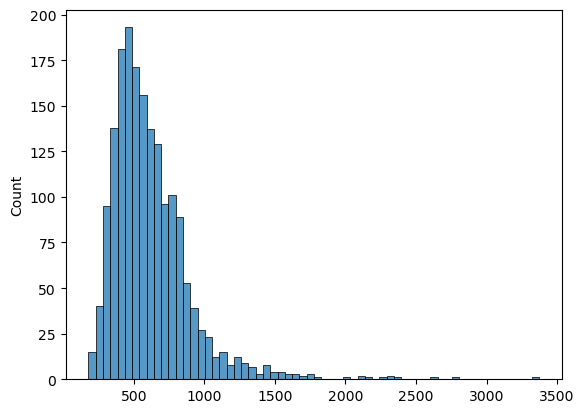

In [102]:
sns.histplot(data_len)

In [100]:
data[740]

{'url': 'https://tailieumoi.vn/cau-hoi/an-nam-cong-san-dang-ra-doi-8-1929-tu-su-phan-hoa-cua-a-dang-lap-hien-b-viet-nam-quoc-dan-dang-c-tan-680556.html',
 'question': 'An Nam Cộng sản đảng ra đời (8 – 1929) từ sự phân hóa của:',
 'choices': ['A. Đảng Lập hiến.',
  'B. Việt Nam Quốc dân đảng.',
  'C. Tân Việt Cách mạng đảng.',
  'D. Hội Việt Nam Cách mạng Thanh niên.'],
 'correct_choice': 'D. Hội Việt Nam Cách mạng Thanh niên.',
 'reason': 'An Nam Cộng sản đảng ra đời (8 – 1929) từ sự phân hóa của Hội Việt Nam\nCách mạng Thanh niên.\n\nChọn D.'}